In [27]:
#Basic pre-reqs:
import numpy as np
import torch
import time
from torch.autograd import Variable
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

#!pip install celluloid

#!export CUDA=cu101 && pip install --upgrade torch-scatter==latest+${CUDA} torch-sparse==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-1.7.0.html
#!pip install --upgrade torch-geometric

# Mount your google drive in google colab
#from google.colab import drive
#drive.mount('/content/drive')

#%cd '/content/drive/MyDrive/ColabNotebooks/MLAM/GN_ABPs'

import models
import simulate

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from sklearn.model_selection import train_test_split

import networkx as nx
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing
from torch_geometric.utils import to_networkx

from models import OGN, varOGN, make_packer, make_unpacker, get_edge_index

from torch_geometric.data import Data, DataLoader
from models import get_edge_index

from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

from tqdm import tqdm

import numpy as onp
onp.random.seed(0)

import pandas as pd


# Loss function: This holds definition of our L1 and KL regularizations:

def new_loss(self, g, augment=True, square=False):
  if square:
      return torch.sum((g.y - self.just_derivative(g, augment=augment))**2)
  else:
      base_loss = torch.sum(torch.abs(g.y - self.just_derivative(g, augment=augment)))
      if test in ['_l1_', '_kl_']:
          s1 = g.x[self.edge_index[0]]
          s2 = g.x[self.edge_index[1]]
          if test == '_l1_':
              m12 = self.message(s1, s2)
              regularization = 1e-2
              #Want one loss value per row of g.y:
              normalized_l05 = torch.sum(torch.abs(m12))
              return base_loss, regularization * batch * normalized_l05 / n**2 * n
          elif test == '_kl_':
              regularization = 1
              #Want one loss value per row of g.y:
              tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
              raw_msg = self.msg_fnc(tmp)
              mu = raw_msg[:, 0::2]
              logvar = raw_msg[:, 1::2]
              full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
              return base_loss, regularization * batch * full_kl / n**2 * n
      return base_loss


# Function to record messages from model

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]]
        s2 = tmp.x[tmp.edge_index[1]]
        tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]


        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info


# Function to visualize network

def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        print("isTensor")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        print("isNotTensor")
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()


In [12]:
import importlib
importlib.reload(simulate)

# Number of simulations to run (it's fast, don't worry):
ns = 8

# Potential (see below for options)
sim = 'r2'

# Number of nodes
n = 7

# Dimension
dim = 2

# Number of time steps
nt = 40

# Time step

dt = 0.01

#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
{'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
{'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
]


#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
# dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
print('Running on', title)


# ??? Why nt//2
from simulate import SimulationDataset
s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt) 

# Update this to your own dataset, or regenerate:
base_str = './'
data_str = title
s.simulate(ns)

# data has [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
data = s.data
accel_data = s.get_acceleration()


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Running on r2_n=7_dim=2_nt=40_dt=0.01


In [13]:
print(s.data[0,0,...])
data.shape

[[ 1.3591251   0.329612    0.9690037   1.0875564   0.          1.        ]
 [ 2.1158817  -1.1862841  -1.3317723   0.51109535  0.          1.        ]
 [ 1.174981   -0.27038378 -0.17853492  1.7897437   0.          1.        ]
 [-0.48743394  0.18600783 -0.32848445 -0.8874241   0.          1.        ]
 [-0.14073446 -0.56184286  0.90058583 -0.28297317  0.          1.        ]
 [-0.9355613   0.81522226  0.2329133  -2.390712    0.          1.        ]
 [-0.43262395 -0.15298584 -1.1773343   0.6433235   0.          1.        ]]


(8, 20, 7, 6)

In [14]:
X = torch.from_numpy(np.concatenate([data[:,i] for i in range(0, data.shape[1], 5)]))
y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, data.shape[1], 5)]))

In [15]:
data[:,0].shape

(8, 7, 6)

In [16]:
print(data.shape[1])
onp.arange(0, data.shape[1], 5)

20


array([ 0,  5, 10, 15])

In [17]:
print(X.shape)
print(y.shape)

torch.Size([32, 7, 6])
torch.Size([32, 7, 2])


In [18]:
# Here we divide train and test data, by default it selects 25% of the data as
# test data. It seems that this is the last 25% of the systems time evolution.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([24, 7, 6])
torch.Size([8, 7, 6])
torch.Size([24, 7, 2])
torch.Size([8, 7, 2])


In [ ]:

# L1 regularization

aggr = 'add'
hidden = 300

test = '_l1_'


#This test applies an explicit bottleneck:

msg_dim = 100
n_f = data.shape[3]


# Custom data loader
# HERE WE GENERATE THE CONECTIVITY TENSOR

edge_index = get_edge_index(n, sim)


# Initiate the model

#######
# GPU #
#######

# if test == '_kl_':
#     ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).to(device)
# else:
#     ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).to(device)

# messages_over_time = []
# ogn = ogn.to(device)

# Test the model
# _q = Data(
#     x=X_train[0].to(device),
#     edge_index=edge_index.to(device),
#     y=y_train[0].to(device))
# ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 

#######
# CPU #
#######

if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cpu()

messages_over_time = []
ogn = ogn.cpu()





# Test the model
_q = Data(
    x=X_train[0].cpu(),
    edge_index=edge_index.cpu(),
    y=y_train[0].cpu())
ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 






## Set up training

# Organize into data loader:
# n: number of nodes (particles).

batch = int(64 * (4 / n)**2)
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

/home/npic/abp_inference/abp_inference/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [21]:
(64*(4/7)**2)

20.897959183673468

In [22]:
print(len(trainloader.dataset))
print(len(testloader.dataset))

24
8


In [23]:
print(trainloader.dataset[0])
print(testloader.dataset[0])

Data(x=[7, 6], edge_index=[2, 42], y=[7, 2])
Data(x=[7, 6], edge_index=[2, 42], y=[7, 2])


In [24]:
trainloader.dataset

[Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6], edge_index=[2, 42], y=[7, 2]),
 Data(x=[7, 6

{0: array([-0.52480656,  1.1856287 ], dtype=float32),
 1: array([ 0.9443292, -1.0465018], dtype=float32),
 2: array([1.279415 , 0.2963645], dtype=float32),
 3: array([ 0.23018403, -1.020589  ], dtype=float32),
 4: array([1.5135585, 1.1048621], dtype=float32),
 5: array([ 0.5725636 , -0.60636204], dtype=float32),
 6: array([-0.95111096, -0.23268104], dtype=float32)}

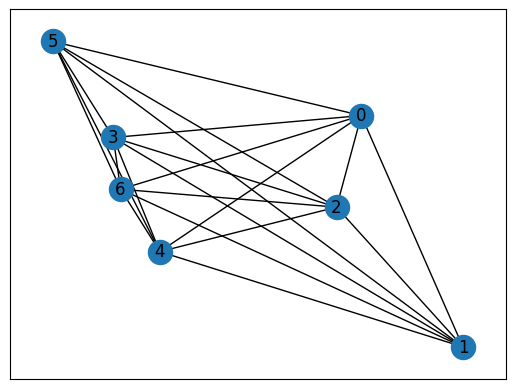

In [25]:
pos0 = [{i : trainloader.dataset[j].x[i,0:2].numpy() 
        for i in range(0,n)} for j in range(0, len(trainloader.dataset))]

G = to_networkx(trainloader.dataset[2], to_undirected=True)
nx.draw_networkx(G, pos=pos0[0], with_labels=True)

pos0[1]


In [ ]:

#data = None
#accel_data = None

#data = onp.load("data_n{0}.npy".format(n))
#accel_data = onp.load("accel_data_n{0}.npy".format(n))

X = torch.from_numpy(np.concatenate([data[:, i] for i in range(0, data.shape[1], 5)]))
y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, data.shape[1], 5)]))

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)


# L1 regularization

aggr = 'add'
hidden = 300

test = '_l1_'


#This test applies an explicit bottleneck:

msg_dim = 100
n_f = data.shape[3]


# Custom data loader

edge_index = get_edge_index(n, sim)


# Initiate the model

if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).to(device)
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).to(device)

messages_over_time = []
ogn = ogn.to(device)


# Test the model
_q = Data(
    x=X_train[0].to(device),
    edge_index=edge_index.to(device),
    y=y_train[0].to(device))
ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 






## Set up training

# Organize into data loader:

batch = int(64 * (4 / n)**2)
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

# We'll use OneCycleLR for fast training:








# Set up optimizer and training parameters: Use 200 epochs for full version; can use fewer for test.
init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 5
epoch = 0


batch_per_epoch = int(1000*10 / (batch/32.0))

sched = OneCycleLR(opt, max_lr=init_lr,
                  steps_per_epoch=batch_per_epoch,#len(trainloader),
                  epochs=total_epochs, final_div_factor=1e5)






# Organize the recording of messages over time This is for fitting the forces, and extracting laws:

test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)



### Train the model:
# Training loop
recorded_models = []

start_time = time.time()
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.to(device)
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x.to(device)
            ginput.y = ginput.y.to(device)
            ginput.edge_index = ginput.edge_index.to(device)
            ginput.batch = ginput.batch.to(device)
            if test in ['_l1_', '_kl_']:
                loss, reg = new_loss(ogn, ginput, square=False)
                ((loss + reg)/int(ginput.batch[-1]+1)).backward()
            else:
                loss = ogn.loss(ginput, square=False)
                (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)

    cur_loss = total_loss/num_items
    print(cur_loss)
    cur_msgs = get_messages(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    
    ogn.cpu()

    recorded_models.append(ogn.state_dict())

In [ ]:
trainloader.dataset

[Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2]),
 Data(edge_index=[2, 380], x=[20, 6], y=[20, 2])]

# **Scaling**

In [ ]:
# Number of simulations to run (it's fast, don't worry):
ns = 100

# Potential (see below for options)
sim = 'spring'

# Number of nodes
# n = 2

# Dimension
dim = 2

# Number of time steps
nt = 100

# Time step

dt = 0.01

#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
{'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
{'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
]


#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
# dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

for i in range(0,9):

  n=i+2

  title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
  print('Running on', title)


  # ??? Why nt//2
  from simulate import SimulationDataset
  s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt) 

  # Update this to your own dataset, or regenerate:
  base_str = './'
  data_str = title
  s.simulate(ns)

  # data has [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
  data = s.data
  accel_data = s.get_acceleration()
  
  onp.save("data_n{0}.npy".format(n), data)
  onp.save("accel_data_n{0}.npy".format(n), accel_data)

  print(i)







Running on spring_n=2_dim=2_nt=100_dt=0.01
0
Running on spring_n=3_dim=2_nt=100_dt=0.01
1
Running on spring_n=4_dim=2_nt=100_dt=0.01
2
Running on spring_n=5_dim=2_nt=100_dt=0.01
3
Running on spring_n=6_dim=2_nt=100_dt=0.01
4
Running on spring_n=7_dim=2_nt=100_dt=0.01
5
Running on spring_n=8_dim=2_nt=100_dt=0.01
6
Running on spring_n=9_dim=2_nt=100_dt=0.01
7
Running on spring_n=10_dim=2_nt=100_dt=0.01
8


In [ ]:
curloss=onp.zeros(9)
execTime=onp.zeros(9)

for ii in range(0,9):

  n=ii+2
  
  data = None
  accel_data = None

  data = onp.load("data_n{0}.npy".format(n))
  accel_data = onp.load("accel_data_n{0}.npy".format(n))

  X = torch.from_numpy(np.concatenate([data[:, i] for i in range(0, data.shape[1], 5)]))
  y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, data.shape[1], 5)]))

  X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)


  # L1 regularization

  aggr = 'add'
  hidden = 300

  test = '_l1_'


  #This test applies an explicit bottleneck:

  msg_dim = 100
  n_f = data.shape[3]


  # Custom data loader

  edge_index = get_edge_index(n, sim)


  # Initiate the model

  if test == '_kl_':
      ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).to(device)
  else:
      ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).to(device)

  messages_over_time = []
  ogn = ogn.to(device)


  # Test the model
  _q = Data(
      x=X_train[0].to(device),
      edge_index=edge_index.to(device),
      y=y_train[0].to(device))
  ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 






  ## Set up training

  # Organize into data loader:

  batch = int(64 * (4 / n)**2)
  trainloader = DataLoader(
      [Data(
          Variable(X_train[i]),
          edge_index=edge_index,
          y=Variable(y_train[i])) for i in range(len(y_train))],
      batch_size=batch,
      shuffle=True
  )

  testloader = DataLoader(
      [Data(
          X_test[i],
          edge_index=edge_index,
          y=y_test[i]) for i in range(len(y_test))],
      batch_size=1024,
      shuffle=True
  )

  # We'll use OneCycleLR for fast training:








  # Set up optimizer and training parameters: Use 200 epochs for full version; can use fewer for test.
  init_lr = 1e-3

  opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

  # total_epochs = 200
  total_epochs = 5
  epoch = 0


  batch_per_epoch = int(1000*10 / (batch/32.0))

  sched = OneCycleLR(opt, max_lr=init_lr,
                    steps_per_epoch=batch_per_epoch,#len(trainloader),
                    epochs=total_epochs, final_div_factor=1e5)






  # Organize the recording of messages over time This is for fitting the forces, and extracting laws:

  test_idxes = onp.random.randint(0, len(X_test), 1000)

  #Record messages over test dataset here:
  newtestloader = DataLoader(
      [Data(
          X_test[i],
          edge_index=edge_index,
          y=y_test[i]) for i in test_idxes],
      batch_size=len(X_test),
      shuffle=False
  )



  ### Train the model:
  # Training loop
  recorded_models = []

  start_time = time.time()
  for epoch in tqdm(range(epoch, total_epochs)):
      ogn.to(device)
      total_loss = 0.0
      i = 0
      num_items = 0
      while i < batch_per_epoch:
          for ginput in trainloader:
              if i >= batch_per_epoch:
                  break
              opt.zero_grad()
              ginput.x = ginput.x.to(device)
              ginput.y = ginput.y.to(device)
              ginput.edge_index = ginput.edge_index.to(device)
              ginput.batch = ginput.batch.to(device)
              if test in ['_l1_', '_kl_']:
                  loss, reg = new_loss(ogn, ginput, square=False)
                  ((loss + reg)/int(ginput.batch[-1]+1)).backward()
              else:
                  loss = ogn.loss(ginput, square=False)
                  (loss/int(ginput.batch[-1]+1)).backward()
              opt.step()
              sched.step()

              total_loss += loss.item()
              i += 1
              num_items += int(ginput.batch[-1]+1)

      cur_loss = total_loss/num_items
      print(cur_loss)
      cur_msgs = get_messages(ogn)
      cur_msgs['epoch'] = epoch
      cur_msgs['loss'] = cur_loss
      messages_over_time.append(cur_msgs)
      
      ogn.cpu()

      recorded_models.append(ogn.state_dict())
      
  execTime[ii] = time.time() - start_time
  curloss[ii] = cur_loss





 20%|██        | 1/5 [00:19<01:19, 19.95s/it]

4.600963364413056


 40%|████      | 2/5 [00:39<00:59, 19.95s/it]

1.877331903130701


 60%|██████    | 3/5 [01:00<00:40, 20.12s/it]

0.6428045418915289


 80%|████████  | 4/5 [01:20<00:20, 20.15s/it]

0.26223884994393365


  0%|          | 0/5 [00:00<?, ?it/s]

0.09141844771642214


 20%|██        | 1/5 [00:28<01:52, 28.25s/it]

7.307294647658556


 40%|████      | 2/5 [00:56<01:25, 28.34s/it]

2.6218347988990285


 60%|██████    | 3/5 [01:25<00:56, 28.33s/it]

1.0893115162791656


 80%|████████  | 4/5 [01:53<00:28, 28.34s/it]

0.453657749578787


  0%|          | 0/5 [00:00<?, ?it/s]

0.11213621846434205


 20%|██        | 1/5 [00:40<02:42, 40.64s/it]

12.672796658651276


 40%|████      | 2/5 [01:21<02:02, 40.69s/it]

4.449980289348198


 60%|██████    | 3/5 [02:01<01:21, 40.61s/it]

1.776701557924336


 80%|████████  | 4/5 [02:42<00:40, 40.64s/it]

0.7286214214928346


  0%|          | 0/5 [00:00<?, ?it/s]

0.12361844129791358
16.251903555703446


 20%|██        | 1/5 [00:57<03:50, 57.63s/it]

5.240659064199258


 40%|████      | 2/5 [01:54<02:52, 57.54s/it]

2.2839332781877184


 60%|██████    | 3/5 [02:52<01:55, 57.60s/it]

0.9497137830581986


 80%|████████  | 4/5 [03:50<00:57, 57.57s/it]

0.1588989896591905


  0%|          | 0/5 [00:00<?, ?it/s]

17.224450823080403


 20%|██        | 1/5 [01:16<05:05, 76.37s/it]

5.3063084395840585


 40%|████      | 2/5 [02:32<03:48, 76.29s/it]

2.52274660278457


 60%|██████    | 3/5 [03:48<02:32, 76.27s/it]

1.0530189221042432


 80%|████████  | 4/5 [05:04<01:16, 76.27s/it]

0.1720548631158216


  0%|          | 0/5 [00:00<?, ?it/s]

28.807488605300314


 20%|██        | 1/5 [01:41<06:45, 101.34s/it]

8.838417829123793


 40%|████      | 2/5 [03:22<05:03, 101.33s/it]

4.191259093214997


 60%|██████    | 3/5 [05:04<03:22, 101.39s/it]

1.788855936765905


 80%|████████  | 4/5 [06:45<01:41, 101.39s/it]

0.2935164096377786


  0%|          | 0/5 [00:00<?, ?it/s]

30.42405432396168


 20%|██        | 1/5 [02:03<08:12, 123.10s/it]

9.306152364918193


 40%|████      | 2/5 [04:06<06:09, 123.18s/it]

4.636468843391056


 60%|██████    | 3/5 [06:09<04:06, 123.10s/it]

1.9265303448242732


 80%|████████  | 4/5 [08:12<02:03, 123.20s/it]

0.31845872095899114


  0%|          | 0/5 [00:00<?, ?it/s]

42.08324425117463


 20%|██        | 1/5 [02:40<10:41, 160.35s/it]

14.066581405491076


 40%|████      | 2/5 [05:20<08:00, 160.23s/it]

6.962661142905068


 60%|██████    | 3/5 [08:01<05:20, 160.49s/it]

2.957296612049027


 80%|████████  | 4/5 [10:44<02:41, 161.16s/it]

0.5120104143452031


  0%|          | 0/5 [00:00<?, ?it/s]

53.06150375523567


 20%|██        | 1/5 [03:11<12:46, 191.70s/it]

17.572723817789555


 40%|████      | 2/5 [06:23<09:35, 191.79s/it]

9.052033546638489


 60%|██████    | 3/5 [09:36<06:24, 192.16s/it]

3.867786881995201


 80%|████████  | 4/5 [12:49<03:12, 192.38s/it]

0.6967016122542322


100%|██████████| 5/5 [16:03<00:00, 192.69s/it]


In [ ]:
nParts=[2,3,4,5,6,7,8,9,10]

In [ ]:
onp.save("trainingTimeVSnParticles.npy", execTime)
onp.save("lossVSnParticles.ny", curloss)


Text(0, 0.5, 'Loss')

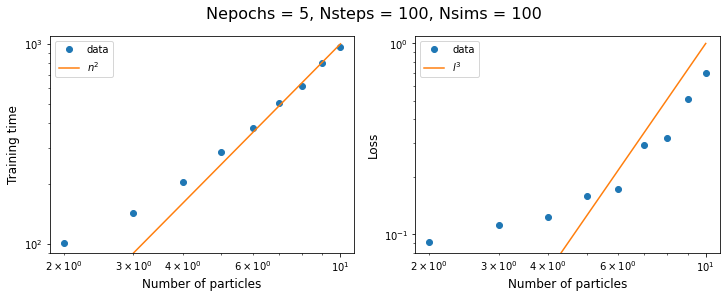

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

fig.suptitle('Nepochs = 5, Nsteps = 100, Nsims = 100', fontsize=16)

ax1.plot(nParts, execTime, 'o', label='data')
ax1.plot(nParts, 10*onp.square(nParts), '-', label='$n^2$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(90,1100)
ax1.legend()
# ax1.grid(True)
ax1.set_xlabel('Number of particles', fontsize=12)
ax1.set_ylabel('Training time', fontsize=12)
#ax1.axes.get_xaxis().set_visible(False)

ax2.plot(nParts, curloss, 'o', label='data')
ax2.plot(nParts, 0.001*onp.power(nParts,3), '-', label='$l^3$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(0.08,1.1)
ax2.legend()
ax2.set_xlabel('Number of particles', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)

In [ ]:
fig.savefig('trainingTime-LossVSnParticles.png')